In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import sys

# define momentum calculation
def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x,returns)
    return ((1+slope)**252)*(rvalue**2)

In [2]:
# read data for filter
net_prof = pd.read_excel("netprofitmagin.xlsx")
gross_prof = pd.read_excel("grossprofitmagin.xlsx")
roe = pd.read_excel("roe4season.xlsx")

net_prof.set_index("Date",inplace=True)
gross_prof.set_index("Date",inplace=True)
roe.set_index("Date",inplace=True)

In [3]:
# calculate constrants
# filter with restricted to gross_prof>20, net_prof>10, roe>10
company = [i for i in net_prof.columns]
month_dates = [i for i in net_prof.index]

results = {}
for date in month_dates:
    result = []
    for c in company:
        if not pd.isnull(net_prof.loc[date][c]) and not pd.isnull(gross_prof.loc[date][c]) and not pd.isnull(roe.loc[date][c]):
            if net_prof.loc[date][c] > 10 and roe.loc[date][c]>10 and gross_prof.loc[date][c]> 20:
                result = result + [c]
    results[date] = result
    #print(date)
    #print(len(result))
    #print(result)

In [4]:
# read data for momentum
closes = pd.read_excel("closes.xlsx")
closes.set_index("Date",inplace=True)
closes_with_date = pd.read_excel("closes.xlsx")

ValueError: x and y must have same first dimension, but have shapes (180,) and (99,)

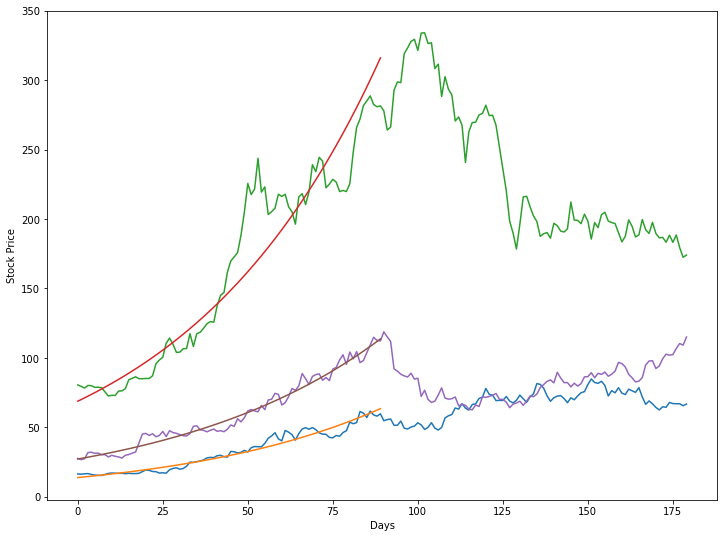

In [10]:
# this part is to show momentum results
# calculate momentum
momentums = closes.copy(deep=True)
for c in company:
    momentums[c] = closes[c].rolling(90).apply(momentum, raw=False)

# Plot best 5
plt.figure(figsize = (12,9))
plt.xlabel('Days')
plt.ylabel('Stock Price')

bests = momentums.max().sort_values(ascending = False).index[:5]
for best in bests:
    end = momentums[best].index.get_loc(momentums[best].idxmax())
    rets = np.log(closes[best].iloc[end - 90 : end])
    x = np.arange(len(rets))
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    plt.plot(np.arange(180), closes[best][end-90:end+90])
    plt.plot(x, np.e ** (intercept + slope*x))

In [5]:
# Decision making
risk_factor = 0.001 # 0.1%, which is 10 basis points

# SPY从200天前开始，close从100天前开始，atr20从100-20=80天前开始，momentum从100-90=10天前开始，都有offset
# offset先处理好，最后都从2016-06-30输入
class strategy():
    # 整个strategy应该从2016-06-30开始
    def __init__(self,risk_factor, company, init_cash, momentum_w_index, closes, SPY, SP200, SP100, filtering, momentum, atr20) -> None:
        self.company_name = company
        self.risk_factor = risk_factor
        self.i = 0
        self.cash = init_cash
        self.value = 0
        self.SPY = SPY  #大盘
        self.SP200 = SP200  #大盘200日均线
        self.close = closes #个股
        self.close_ma100 = SP100    #个股100日均线
        self.momentum_w_index = momentum_w_index #个股，以date为index
        self.momentum = momentum    #个股momentum
        self.filtering = filtering
        self.atr20 = atr20  #个股atr20
        self.j = 0
        self.period = list(filtering.keys()) # date checking for seasons
        self.hold_stocks = {} # 持股公司：份额
    
    def get_value(self):
        return self.value

    def get_cash(self):
        return self.cash

    def next(self):
        self.update_value()
        t0 = self.get_value()
        if self.i %5 == 0: # re-portfolio every 5 working days (1 week)
            self.reportfolio()
        if self.i %10 ==0: # re-position every 10 working days (2 weeks)
            self.reposition()
        self.update_value() # 每日更新value
        t1 = self.get_value()
        if np.abs(t0-t1)>100:
            print("The date is",self.i)
        self.i += 1
    
    def sell(self, name):
        # sell stocks
        if pd.isnull(self.close.loc[self.i][name]):
            print("Warning")
        self.cash = self.cash + self.hold_stocks[name]*self.close.loc[self.i][name]
        del self.hold_stocks[name]

    def buy(self, name, size):
        self.update_value()
        t0 = self.get_value()

        # buy stocks
        if pd.isnull(self.close.loc[self.i][name]):
            print("Warning")
        is_zero = False
        if name in list(self.hold_stocks.keys()):
            self.sell(name)
            
        if self.cash - size*self.close.loc[self.i][name] > 0:
            self.hold_stocks[name] = size
            self.cash = self.cash - size*self.close.loc[self.i][name]
            is_zero = False
        else:
            size = self.cash/self.close.loc[self.i][name]
            self.hold_stocks[name] = size
            self.cash = 0
            is_zero = True
        

        self.update_value()
        t1 = self.get_value()
        if(np.abs(t0-t1)>100):
            print("buy problem")
        return is_zero

    def update_value(self):
        # update total values
        self.value = 0
        for c in list(self.hold_stocks.keys()):
            if pd.isnull(self.close.loc[self.i][c]):
                print("Warning")
            self.value += self.close.loc[self.i][c]*self.hold_stocks[c]
        self.value += self.cash

    def reportfolio(self):
        # First find filtered companies
        t0 = self.get_value()
        today = self.close.loc[self.i]['Date']
        if self.j == len(self.period)-1:
            filter_companies = self.filtering[self.period[self.j]]
        elif today < self.period[self.j + 1]:
            filter_companies = self.filtering[self.period[self.j]]
        else:
            self.j = self.j + 1
            filter_companies = self.filtering[self.period[self.j]]

        # Second, for every stocks in hold, check if to sell.
        comps = list(self.hold_stocks.keys())
        for c in comps:
            if c not in filter_companies or self.close.loc[self.i][c] < self.close_ma100.loc[self.i][c] or self.SPY.loc[self.i]['close'] < self.SP200.loc[self.i]['close']:
                self.sell(c)

        # Third, determine if to buy
        if self.SPY.loc[self.i]['close'] < self.SP200.loc[self.i]['close']:
            return

        self.update_value()
        t1 = self.get_value()

        # Forth, determine what to buy
        # Formulate rankings. Check ma100
        rankings = []
        for c in list(self.momentum_w_index.sort_values(today,1,ascending = False).columns):
            if c in filter_companies and self.close.loc[self.i][c]>=self.close_ma100.loc[self.i][c] and not pd.isnull(self.atr20.loc[self.i][c]) and self.atr20.loc[self.i][c]>0.0001:
                rankings += [c]
        # Buy stocks. Before buying, checking if enough money to buy
        for c in rankings:
            self.update_value()
            size = self.value*self.risk_factor/self.atr20.loc[self.i][c]
            if self.buy(c,size): # which means cash = 0
                break
        self.update_value()
        t2 = self.get_value()
        if np.abs(t0-t2)>100:
            print("t0 "+str(t0)+" t1 "+str(t1)+" t2 "+str(t2))


    def reposition(self):
        # re-balance all stocks
        today = self.close.loc[self.i]['Date']
        if self.j == len(self.period)-1:
            filter_companies = self.filtering[self.period[self.j]]
        elif today < self.period[self.j + 1]:
            filter_companies = self.filtering[self.period[self.j]]
        else:
            self.j = self.j + 1
            filter_companies = self.filtering[self.period[self.j]]

        if self.SPY.loc[self.i]['close'] < self.SP200.loc[self.i]['close']:
            return
        
        for c in list(self.hold_stocks.keys()):
            self.sell(c)

        rankings = []
        for c in list(self.momentum_w_index.sort_values(today,1,ascending = False).columns):
            if c in filter_companies and self.close.loc[self.i][c]>=self.close_ma100.loc[self.i][c] and not pd.isnull(self.atr20.loc[self.i][c]) and self.atr20.loc[self.i][c]>0.0001:
                rankings += [c]
        # Buy stocks. Before buying, checking if enough money to buy
        for c in rankings:
            self.update_value()
            size = self.value*self.risk_factor/self.atr20.loc[self.i][c]
            if self.buy(c,size): # which means cash = 0
                return

In [12]:
# read data for momentum
closes = pd.read_excel("closes.xlsx")
closes.set_index("Date",inplace=True)
closes_with_date = pd.read_excel("closes.xlsx")

atr20 = pd.read_excel("atr20.xlsx")
momentums = pd.read_excel("momentums.xlsx")
sma100 = pd.read_excel("sma100.xlsx")
sma200 = pd.read_excel("sma200.xlsx")
spya = pd.read_excel("SPYA.xlsx")
momentums_w_index = pd.read_excel("momentums.xlsx")
momentums_w_index.set_index("Date",inplace=True)

sp_average = pd.read_excel("average.xlsx")
#sp_average.set_index("Date",inplace = True)

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_61156/648526672.py:117: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  for c in list(self.momentum_w_index.sort_values(today,1,ascending = False).columns):
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_61156/648526672.py:150: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  for c in list(self.momentum_w_index.sort_values(today,1,ascending = False).columns):


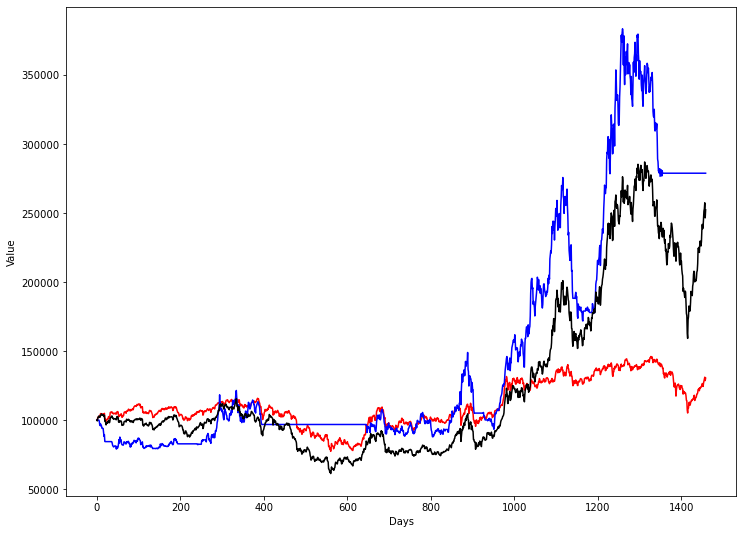

In [14]:
risk_factor = 0.01 # 0.1%, which is 10 basis points
init_cash = 100000

behavior = strategy(risk_factor, company, init_cash, momentums_w_index, closes_with_date, spya, sma200, sma100, results, momentums, atr20)
profit = spya.copy(deep=True)
cash = spya.copy(deep=True)
plt.figure(figsize = (12,9))
plt.xlabel('Days')
plt.ylabel('Value')
decision_range = len(closes)
x = np.arange(decision_range)
for i in range(decision_range):
    #print(behavior.hold_stocks)
    behavior.next()
    profit.loc[i,'close'] = behavior.get_value()
    cash.loc[i,'close'] = behavior.get_cash()
plt.plot(x, spya['close']*init_cash/spya.loc[0]['close'], color = 'r')
plt.plot(x, profit['close'], color = 'b')
plt.plot(x, sp_average['close']*init_cash/sp_average.loc[0]['close'],color = 'black')

In [11]:
spya

,Date,close
0,2016-06-30,4105.9422
1,2016-07-01,4103.0126
2,2016-07-04,4178.9591
3,2016-07-05,4195.2216
4,2016-07-06,4212.8371
...,...,...
1454,2022-06-24,5268.5293
1455,2022-06-27,5320.7534
1456,2022-06-28,5383.9717
1457,2022-06-29,5282.4185
